In [15]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# GEOFILE - Obce CZ pro choropleth mapy

geo_file_path = '../map/files/OBCE_P-wgs84.shp'

# https://towardsdatascience.com/plot-choropleth-maps-with-shapefiles-using-geopandas-a6bf6ade0a49
# https://towardsdatascience.com/how-to-visualize-data-on-top-of-a-map-in-python-using-the-geoviews-library-part-2-e61a48ee6c3d
# https://data.gov.cz/články/kartogram-choropleth
map_df = gpd.read_file(geo_file_path, driver='ESRI Shapefile')
map_df = map_df.rename(columns={'KOD': 'kod_obec', 'NAZEV': 'nazev_obec'})
# shapes_df.head()
# types 

map_df = map_df[['kod_obec', 'nazev_obec', 'geometry']]
# convert kod_obec to int and nazev_obec to string
map_df['kod_obec'] = map_df['kod_obec'].astype(int)
map_df['nazev_obec'] = map_df['nazev_obec'].astype(str)

plt.rcParams['figure.figsize'] = (12, 9)
sns.set_theme(style="darkgrid", color_codes=True)

# Read in the data
df_census = pd.read_csv('../geodata/census11_21/data_obce_vyhl_nevyhl.csv', sep=',')
df_dluhy = pd.read_csv('../geodata/score/obce_skore_rizikovosti.csv', sep=';')
df = pd.merge(df_census, df_dluhy, on='OBEC_KOD', how='inner')    
df = df.rename(columns={
    'OBEC_KOD': 'kod_obec', 
    'vzdelani_bez_mean': 'Bez vzdělání', 
    'vzdelani_zakl_mean': 'Základní vzdělání', 
    'vzdelani_str_bm_mean': 'Středoškolské vzdělání bez maturity', 
    'vzdelani_str_np_mean': 'Středoškolské vzdělání s maturitou', 
    'vzdelani_vo_mean': 'Vyšší odborné vzdělání', 
    'vzdelani_vys_mean': 'Vysokoškolské vzdělání',
    # vek
    'vek_0_14_mean': 'prumerny_vek_0-14',
    'vek_15_19_mean': 'prumerny_vek_15-19',
    'vek_20_29_mean': 'prumerny_vek_20-29',
    'vek_30_39_mean': 'prumerny_vek_30-39',
    'vek_40_49_mean': 'prumerny_vek_40-49',
    'vek_50_59_mean': 'prumerny_vek_50-59',
    'vek_60_64_mean': 'prumerny_vek_60-64',
    'vek_65_69_mean': 'prumerny_vek_65-69',
    'vek_70_79_mean': 'prumerny_vek_70-79',
    'vek_80_inf_mean': 'prumerny_vek_80+',
})

# create columns with children, adults, seniors
df['dospeli'] = df['prumerny_vek_20-29'] + df['prumerny_vek_30-39'] + df['prumerny_vek_40-49'] + df['prumerny_vek_50-59'] + df['prumerny_vek_60-64']
df['mladistvi'] = df['prumerny_vek_0-14'] + df['prumerny_vek_15-19']
df['seniori'] =  df['prumerny_vek_65-69'] + df['prumerny_vek_70-79'] + df['prumerny_vek_80+']


# oD.cat -> into categorical value
size_cat_type = CategoricalDtype(categories=["0-100", "100-200", "200-500", "500-1k", "1-2k", "2-5k", "5-20k", "20-50k", "50-200k", "200k+"], ordered=True)
df['oD.cat'] = df['oD.cat'].astype(size_cat_type)

map_df = map_df.merge(df, on='kod_obec')






In [16]:
def make_plot(x,y, title='', ax=None, show=True):
    # p1 = sns.scatterplot(x=x, y=y, data=df, hue='score', palette='coolwarm', legend=True)
    # p1.map_dataframe(sns.lineplot, x, y, color='g')
    sns.regplot(data=df, x=x, y=y, ax=ax)
    if ax:
        ax.set_title(title)
    else:
        plt.title(title)
    if show:
        plt.show()
    

In [17]:
def make_plot_proc(x,y,proc):
    plt.xlim(0, proc)
    plt.ylim(0, proc)
    sns.scatterplot(x=x, y=y, data=df)
    plt.show()


In [18]:
def make_plot_all_in_one(x,y):
    # sns.scatterplot(x=x, y=y, data=df)
    sns.regplot(data=df, x=x, y=y)

# Úvod
V poslední několika letech jsme v České republice mohli zaznamenat několik zajímavých mikroekonomických událostí. Výrazně narostla kupní síla, obyvatelstvo více utrácelo, ale i se znatelně zadlužilo. To se mimo jiné projevilo i na růstu e-commerce a maloobchodu. Další nevídanou situací byl i znatelný růst cen nemovitostí napříč českými městy i suburbii způsobený mimojiné nezastavitelnou poptávkou po novém bydlení, investicím a nebo jen touze získat více místa či zahradu.

To vše, vzhledem k negativnímu vývoji ekonomické situace, má vliv na rekordní zadlužení obyvatelstva. Každá instituce poskytující úvěry fyzickým osobám se tak musí chovat opatrněji a věnovat více pozornosti, komu peníze poskytuje. V tomto projektu se podíváme na to, jak lze využít moderních technologií, věřejně dostupných dat a data science ke svému prospěchu.

Pro finanční instituace poskytující úvěry, či obchodníky nabízející své zboží nebo služby s odloženou splatností, by tak mohlo být zajímavé, jaké faktory ovlivňují schopnost splácení klientů. To by samo o sobě mohlo napomoci k větší obezřetnosti prodejce, přesnějšímu marketingovému cílení a nebo naopak k uzpůsobení služeb jednotlivým skupinám obyvatelstva.

Podíváme se tak na vztah mezi agregovanými daty ze sčítání lidu a podílu exekucí a bankrotů v jednotlivých obcích a pokusíme se z nich odvodit, jaké sociodemografických údaje ovlivňují, zda jsou obyvatelé schopni splácet své dluhy či nikoli.

## Co od dat očekáváme
Klást budeme důraz na to, jaké sociodemografické údaje ovlivňují, zda jsou lidé schopni splácet své dluhy. Přesněji řečeno, jaký je vztah mezi podílem exekucí a bankrotů s různými údaji o obyvatelstvu.

### Očekávání a překvapení
Již při prvním pohledu na data (resp. jejich strukturu a obsah) člověk začne mít nějaká první očekávání - například, že by se mohlo ukázat, že větší podíl exekucí a bankrotů má vliv na věkovou strukturu obyvatelstva, nebo na vzdělání. To by bylo překvapení, protože by to znamenalo, že lidé s vyšším vzděláním jsou schopni splácet své dluhy lépe než ostatní. Je tomu tak nebo se ukáže, že věková struktura a vzdělání nemají žádný vliv na schopnost splácet dluhy? Nemůže se ukázat, že porovnávat věkovou strukturu a vzdělání nedává příliš smysl neboť věková struktura a vzdělání mohou záviset i na faktu, že míra dosaženého vzdělání postupně roste? 
Očekávání tak musíme ověřit a překvapení najít v průběhu bádání. 

Výsledkem tohoto projektu by mělo být zobrazení vztahu mezi sociodemografickými údaji a podílem exekucí a bankrotů v jednotlivých obcích. Výsledný model by mohl být schopen na základě několika sociodemografických údajů o populaci odhadnout míru její zadluženosti.

# Data
Využijeme vybrané výsledky ze sčítání lidu z roku 2011 a 2021 a data o exekucích a bankrotech za jednotlivé obce České republiky.

## Původ dat
Celá datová sada za jednotlivé obce České republiky obsahuje:

* vybrané výsledky sčítání lidu 2011 a 2021
* počet obyvatel celkem v jednotlivých sociodemografických skupinách
* výskyt vybraných trestných činů
* podíl osob v bankrotu či exekuci

Byla stažena ze stránek [nextcloud.profinit.eu](https://nextcloud.profinit.eu/index.php/s/CDbHbfa6R7M9DLA/download?path=%2Fdata&files=geodata.zip), pravděpodobně je ale původ neagregovaných datasetů od [Českého statistického úřadu](https://www.czso.cz/).

## Stručný popis
Pojďme si představit používané datasety a jejich strukturu. Oba datasety jsou díky dělení na obce velmi granulované a tím i relativně dlouhé.

### Sčítání lidu (Cenzus)
Data ze sčítání lidu z let 2011 a 2021 (`geodata/census11_21/data_obce_vyhl_nevyhl.csv`) jsou obsáhlá v jednom souboru a obsahují informace o jednotlivých obcích. Každá obec má svůj řádek a sloupce obsahují informace o jednotlivých sociodemografických skupinách. Výsledky jsou však agregované, takže neobsahují informace o jednotlivých obyvatelích, ale o celkovém počtu obyvatel v daných skupinách.
V datech tak máme například pro každou obec v České republice informaci o počtu dětí, vzdělání, věku, rodinného stavu, občanství, ale i o vlastníkovi domů (družstvo, fyz. osoba, obec/stát, podílové) či stavebního materiálu domu, ve kterém obyvatelé žijí a mnoho více.

Dataset je složený z 6246 pozorování o 160 proměnných. Díky tomu je dataset velmi široký a obsahuje velikou škálu sociodemografikcých údajů. Každé pozorování je vytvořeno pro obec, kterých je celkem 6246.

### Exekuce a bankroty
Data o exekucích a bankrotech (`geodata/score/obce_skore_rizikovosti.csv`) jsou dělená dle obcí České republiky a obsahují informace o podílu exekucí (klouzavý průměr za roky 2018-2021) a bankrotů (klouzavý průměr za orky 2018-2021) v jednotlivých obcích. Výsledky jsou agregované, takže neobsahují informace o jednotlivých obyvatelích, ale o celkovém počtu exekucí a bankrotů v dané obci. Mimojiné obsahují i tzv. skóre obce, které je výsledkem normovaného průměru počtu exekucí a bankrotů v obci. Toto skóre je v rozmezí 0 až 1, kde 0 znamená, že v obci nebyly žádné exekuce ani bankroty a 1 znamená, že v obci byly exekuce a bankroty v průměru v každém roce.

Dataset je složený z 6254 pozorování o 10 proměnných. Každé porování je vytvořeno pro obec, kterých je celkem 6254.

## Kvalita dat
Data ze sčítání lidu z nějakého důvodu neobsahují data ze 14 obcí. Dle [struktury území ČR mezi roky 2013 a 2022](https://www.czso.cz/documents/10180/23208674/struktura_uzemi_cr_1_1_2013_az_1_1_2022.xlsx/9565a148-f186-4d47-8dd9-ecd97c66cea1?version=1.0) od ČSÚ je v České republice (od 1.1.2016) celkem 6260 obcí. V našich datech je však "pouze" 6246 resp. 6254 obcí pro dataset exekucí. Těžko říct, zda je to chyba v našich datech, nebo v původních datech od ČSÚ, ale i mezi datasety je rozdíl v 8 obcích, které ve výsledcích ze sčítání lidu chybějí. Konkrétně se jedná o obce:

* Krhová v okrese Vsetín (500062)
  * 2024 obyvatel
* Poličná v okrese Vsetín (500071)
  * 1745 obyvatel
* Bražec v okrese Karlovy Vary (500101)
  * 221 obyvatel
* Doupovské Hradiště v okrese Karlovy Vary (500127)
  * 160 obyvatel
* Kozlov v okrese Olomouc (500135)
  * 270 obyvatel
* Luboměř pod Strážnou v okrese Přerov (500151)
  * 122 obyvatel 
* Město Libavá v okrese Olomouc (500160)
  * 0 obyvatel
* Polná na Šumavě v okrese Český Krumlov (500194)
  * 202 obyvatel

Ač se jedná o obce (pro nás) v relativně zajímavém místě (s předpokládanou horší ekonomickou situací), tak se jedná o relativně malé obce, takže bychom je nemuseli brát v úvahu.

Dle výstupů z nástroje `pandas-profiling` žádný ze zmíněných datasetů nemá problém s chybějícími daty ve sloupcích. Jediné, co je vhodné upravit jsou názvy sloupců, ale ty jsou vždy vysvětleny v přiložených textových souborech.

# Příběhy
Poskytnuté datasety jsou velmi obsáhlé a obsahují veliké množství informací. Na jejich základě by mělo být možné vytvořit (a podložit) veliké množství příběhů. Ukážeme si jeden z nich.

## Vzdělání a dluhy
Této hypotéze se podíváme na vztah vzdělání a zadlužení obyvatel českých obcí. Můžeme nějak využít informace o počtu vysokoškoláků zastoupených v obci k tomu abychom určili míru její zadluženosti?

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/3480500321.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


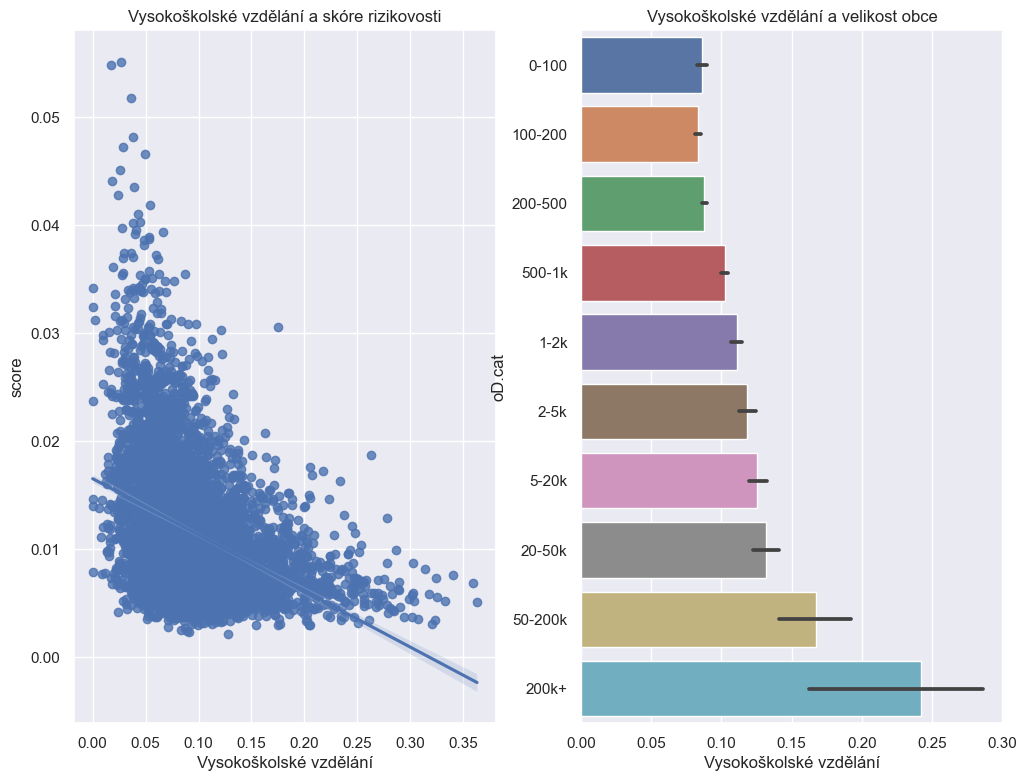

In [19]:
data_edu = ['Vysokoškolské vzdělání']
data_score = ['score']

fig, (ax1, ax2) = plt.subplots(1, 2)

# for edu in data_edu:
#     make_plot(edu, data_score[0], 'Vysokoškolské vzdělání a skóre rizikovosti', ax=ax1)

sns.regplot(data=df, x=data_edu[0], y=data_score[0], ax=ax1)
ax1.set_title('Vysokoškolské vzdělání a skóre rizikovosti')


data_edu = ['Vysokoškolské vzdělání']
# data_edu = ['bez','zakl', 'str_bm', 'str_np', 'vo', 'vys' ]
data_size = ['oD.cat']

# df['oD.cat'].value_counts()

# for edu in data_edu:
#     make_plot(edu, data_score[0])
sns.barplot(x=data_edu[0], ax=ax2, y=data_size[0], data=df)
# plt.ylabel('Velikost obce')
ax2.set_title('Vysokoškolské vzdělání a velikost obce')
# plt.show()
fig.show()




Dle grafů výše se zdá, že s přibývajícím počtem vysokoškoláků v obci klesá i skóre zadlužení obce. To znamená, že obce s vysokoškoláky mají méně dluhů. To je ale jen první pohled na data.
Co když se podíváme na poměr mezi počtem vysokoškoláků a počtem obyvatel v obci? Jak můžeme vidět, s velikostí obce nám roste i počet vysokoškoláků. Jaký vztah tedy má velikost a zadlužení obce?

In [20]:
# data_edu = ['Vysokoškolské vzdělání']
# # data_edu = ['bez','zakl', 'str_bm', 'str_np', 'vo', 'vys' ]
# data_size = ['oD.cat']

# # df['oD.cat'].value_counts()

# # for edu in data_edu:
# #     make_plot(edu, data_score[0])
# sns.catplot(x=data_edu[0], y=data_size[0], data=df, kind="bar", ci=None)
# plt.ylabel('Velikost obce')
# plt.title('Vysokoškolské vzdělání a velikost obce')
# plt.show()

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/73071176.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


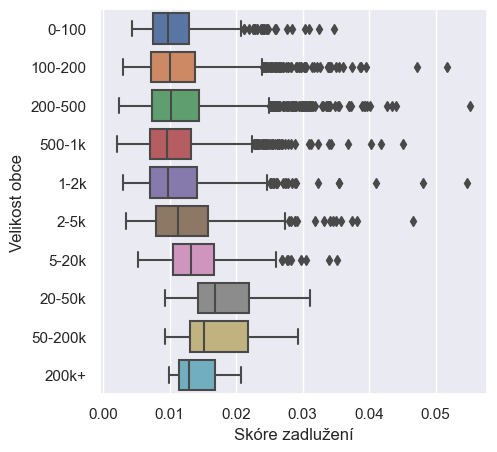

In [21]:
data_score = ['score']
data_size = ['oD.cat']

# for edu in data_edu:
# make_plot(data_score[0], data_size[0])
fig, (ax1) = plt.subplots(1,1, figsize=(5, 5))
sns.boxplot(x=data_score[0], y=data_size[0], data=df, ax=ax1)
ax1.set_ylabel('Velikost obce')
ax1.set_xlabel('Skóre zadlužení')
fig.show()


Pro větší přehlednost a možnou představu (s demografickou a geografickou znalosti ČR) by nám mohla pomoci mapa ČR. Vytvoříme si tedy mapu ČR, kde budeme moci vidět, jak jsou vysokoškoláci a skóre rizikovosti rozděleni po jednotlivých obcích.

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/71848480.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


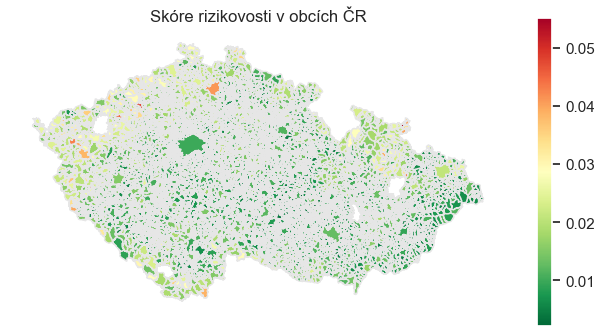

In [22]:
# convert all score to float
# map_df['score_cat'] = pd.cut(map_df['score'], bins=[0, 0.1, 0.2, 0.3, 1.0], labels=['0-10%', '10-20%', '20-30%', '+30%'])

# map_df_no_nan = map_df.dropna(subset=['score'])
# map_df['score_cat'] = pd.qcut(map_df['score'], q=4, labels=['0-25%', '25-50%', '50-75%', '75-100%'])

fig, (ax) = plt.subplots(1, figsize=(8,4))
map_df.plot(column='score', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Skóre rizikovosti v obcích ČR')
fig.show()

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/430419584.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


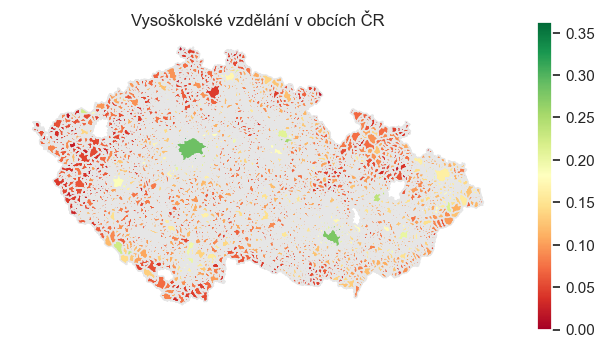

In [23]:
# Vysokoškolské vzdělání

fig, (ax) = plt.subplots(1,figsize=(8,4))

# print(pd.qcut(map_df['Vysokoškolské vzdělání'], 4, labels=['0-25%', '25-50%', '50-75%', '75-100%']))

# bins = [0, 0.02, 0.07, 0.12, 1.0]

# print(map_df['Vysokoškolské vzdělání'].quantile(q=bins))
# print(pd.qcut(map_df['Vysokoškolské vzdělání'], q=4))

# map_df['vs_score'] = pd.cut(map_df['Vysokoškolské vzdělání'], bins=bins, labels=['0-10%', '10-20%', '20-30%', '+30%'])
# map_df['vs_score'] = pd.qcut(map_df['Vysokoškolské vzdělání'], q=4, labels=['0-25%', '25-50%', '50-75%', '75-100%'])
# in order to plot the map colors in relation to the values on previous one (red is bad, green is good, which in this situation is the opposite)
# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('RdYlGn_r')
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()


map_df.plot(column='Vysokoškolské vzdělání', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap=reversed_map)
ax.axis('off')
ax.set_title('Vysoškolské vzdělání v obcích ČR')
fig.show()


Dle výše uvedených map můžeme poměrně hezky vidět, že by teoreticky nějaký vztah mezi vzdělaností a rizikovostí obce opravdu existovat mohl. Dobrým příkladem by mohl být Karlovarský a Ústecký kraj a celkově většina pohraničí (dokonce prakticky kopírující hranici bývalých Sudet).

## Rozvodovost a dluhy
Pojďme si představit druhý příběh, který by mohl člověka napadnout v kontextu dluhů. A to ve vztahu rozvodovosti obyvatel českých obcí. Můžeme nějak využít informace o počtu rozvedených obyvatel v obci k tomu abychom určili míru její zadluženosti? Pojďme se podívat na data.

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/3381698613.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/3381698613.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


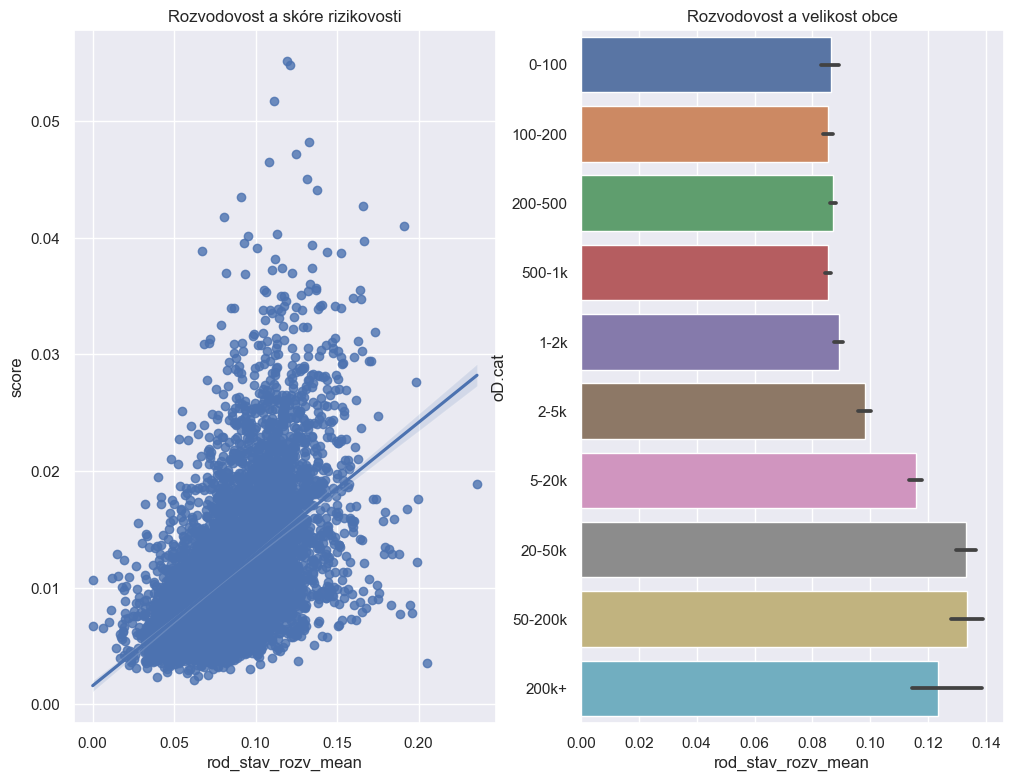

In [24]:
data_divorce = ['rod_stav_rozv_mean']
data_score = ['score']

fig, (ax1, ax2) = plt.subplots(1, 2)

# for edu in data_edu:
#     make_plot(edu, data_score[0], 'Vysokoškolské vzdělání a skóre rizikovosti', ax=ax1)

sns.regplot(data=df, x=data_divorce[0], y=data_score[0], ax=ax1)
ax1.set_title('Rozvodovost a skóre rizikovosti')

data_size = ['oD.cat']
sns.barplot(x=data_divorce[0], ax=ax2, y=data_size[0], data=df)
# plt.ylabel('Velikost obce')
ax2.set_title('Rozvodovost a velikost obce')
# plt.show()
fig.show()

# data_edu = ['Vysokoškolské vzdělání']
# # data_edu = ['bez','zakl', 'str_bm', 'str_np', 'vo', 'vys' ]

# # df['oD.cat'].value_counts()

# # for edu in data_edu:
# #     make_plot(edu, data_score[0])
# sns.barplot(x=data_edu[0], ax=ax2, y=data_size[0], data=df)
# # plt.ylabel('Velikost obce')
# ax2.set_title('Vysokoškolské vzdělání a velikost obce')
# # plt.show()
fig.show()




Opět se může zdát, že nějaký vztah mezi rozvodovostí a zadlužeností obce existuje. Pokud si rozvedené v obcích znázorníme na mapě ČR, můžeme vidět, že nám opět rozvodovost mírně koreluje se skóre rizikovostí. Rozvodovost ale nemůžeme brát jako jediný faktor neboť sami můžeme vidět, jak je nízká rozvodovost v ČR neobvyklá. Jediné oblasti ČR s rozvodovostí pod 5% jsou na hranici se Slovenskem (tedy oblast od Jablůnkova po Uherský Brod a poté oblast vymezená Litomyšlí a Jihlavou (tedy převážně oblast Železných hor a Žďárských vrchů)).

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/596555374.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


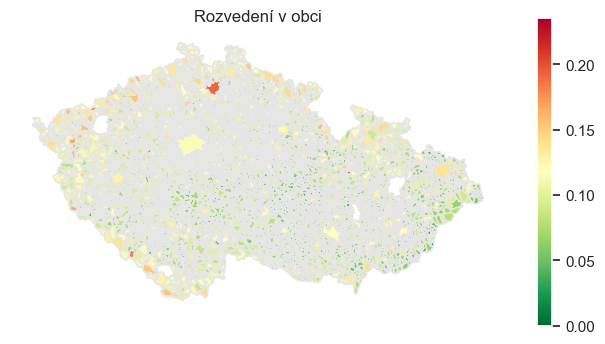

In [25]:
# Rozvedených v obci - choropleth map
# rod_stav_rozv_mean

fig, ax = plt.subplots(1, figsize=(8,4))
map_df.plot(column='rod_stav_rozv_mean', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Rozvedení v obci')
fig.show()


V tuto chvíli by stálo za to se pozastavit a rozvodovost více porovnat s poměrně důležitým faktorem - věkem.

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/2051142230.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


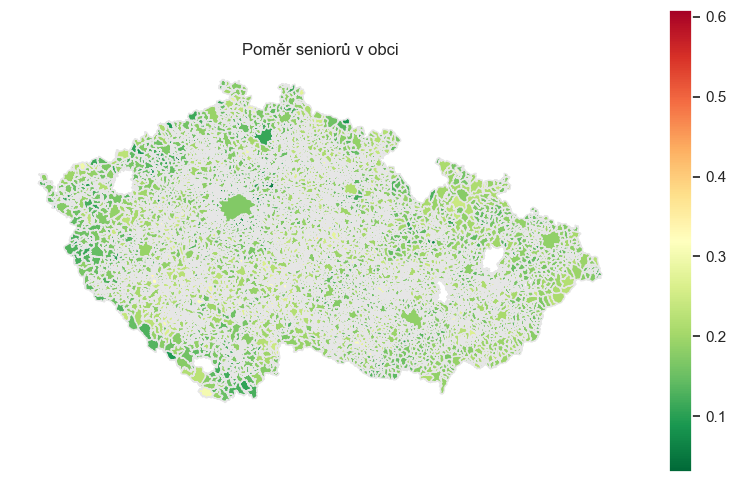

In [26]:
fig, (ax) = plt.subplots(1, figsize=(10,6))
map_df.plot(column='seniori', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap='RdYlGn_r')
ax.axis('off')
ax.set_title('Poměr seniorů v obci')
fig.show()

Můžeme opět náhlednout, že oblasti s nižším zastoupením seniorů opět mírně korelují s vyšším skóré rizikovosti.

Zajímavého úkazu, kterého si můžeme na mapách všimnout je pokaždé výrazné Ralsko (město cca mezi Mělníkem a Libercem). Zprvu jsem ho považoval za chybu v datech, ale po zkontrolování a zjištění faktu, že se jedná o obec známou především díky vojenskému prostoru jenž opustila sovětská armáda se zdají data být správná.

Ač je zkoumání rozvodovosti a dluhů poměrně zajímavé, dále tuto hypotézu rozvíjet nebudeme a bude sloužit jen jako příklad dalšího možného vztahu mezi daty.

# Modelování
V předchozí sekci jsme si ukázali dvě možné hypotézy v kontextu dluhů. V této sekci se pokusíme o vytvoření modelu, který by nám umožnil předpovědět skóre rizikovosti obce na základě vzdělání a rozvodovosti obyvatel. Vytvoříme si tedy model, který na základě vstupních proměnných (sociodemografické údaje) o obci bude schopen předpovídat její skóre rizikovosti. 


V hypotéze diskutující vztah mezi vzděláním a dluhy jsme se snažili zjistit, zda-li je možné nějak využít informace o počtu vysokoškoláků zastoupených v obci k tomu abychom určili míru její zadluženosti. Výsledky nám ukázaly, že vztah mezi vzděláním a zadlužeností obce existuje (nebo to tak alespoň vypadá). Většina obcí s vysokoškoláky má nižší skóre rizikovosti než obce bez vysokoškoláků.
Je nutno ale podoknout jednu poměrně důležitou věc. Úroveň vzdělání (alespoň tzv. "na papíře") v České republice roste. Pokud bychom tedy porovnali standard generace narozené v meziválečném období, velmi pravděpodobně by jako dostačující míru dosaženého vzdělenání jejich doby považovali základní školu. Naopak dnes podobným standardem může být dokončení střední školy s maturitou. 
Za tímto účelem byl vytvořený $vzdelani\_skore$ sloupec, který je vypočítáván jako 
$$
vzdelani\_skore = \frac{\sum_{\text{koeficient vzdělání}}{\text{koeficient vzdělání} * \textit{hodnota}\text{(úroveň vzdělání)}}}{\sum_{\text{koeficient vzdělání}}{\text{koeficient vzdělání}}}
$$. 
Kde $\textit{koeficient vzdělání}$ definujeme jako:
- $1$ pro základní vzdělání
- $2$ pro střední vzdělání bez maturity
- $2.5$ pro střední vzdělání s maturitou
- $2.75$ pro vyšší odborné vzdělání
- $3$ pro vysokoškolské vzdělání

Toto nám umožní rozumně dobře srovnat na podobnou úroveň středoškolské bez maturity, s maturitou a vyšší odborné vzdělání a vyjádřit trochu detailněji vzdělanost obce a nezaměřovat se pouze na vysokoškoláky.

Tímto způsobem jsme vytvořili sloupec, který nám ukazuje, jak moc je vzdělání obce vyšší než standardní vzdělání generace narozené v meziválečném období. Pokud bychom tedy vytvořili mapu ČR, kde by bylo vidět, jak je vzdělání obce vyšší než standardní vzdělání generace narozené v meziválečném období, mohli bychom zjistit, zda-li je vztah mezi vzděláním a zadlužeností obce opravdu existovat mohl.

/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/348873769.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


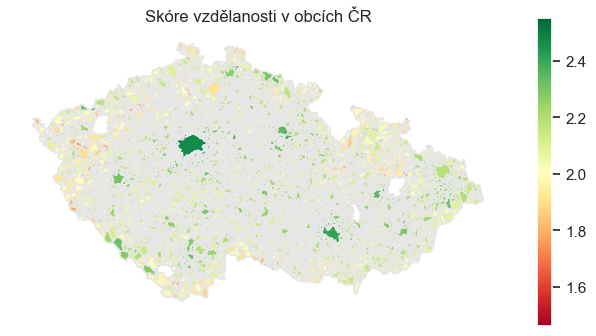

In [27]:
# vzdelani v obcích - choropleth map
# skórizovat vzdelani
#   1: základní vzdělání
#   2: středoškolské vzdělání bez maturity 
#   2.5: středoškolské vzdělání s maturitou
#   2.75: vyšší odborné vzdělání
#   3: vysokoškolské vzdělání

map_df['vzdelanych']=(map_df['Základní vzdělání']+map_df['Středoškolské vzdělání bez maturity']+map_df['Středoškolské vzdělání s maturitou']+map_df['Vysokoškolské vzdělání'])
map_df['vzdelani_score'] =(1*map_df['Základní vzdělání']+2*map_df['Středoškolské vzdělání bez maturity']+2.5*map_df['Středoškolské vzdělání s maturitou']+2.75*map_df['Vyšší odborné vzdělání']+3*map_df['Vysokoškolské vzdělání'])
map_df['vzdelani_score'] = map_df['vzdelani_score'] / map_df['vzdelanych']

# getting the original colormap using cm.get_cmap() function
# orig_map=plt.cm.get_cmap('RdYlGn_r')
# reversing the original colormap using reversed() function
# reversed_map = orig_map.reversed()

fig, ax = plt.subplots(1, figsize=(8,4))
map_df.plot(column='vzdelani_score', linewidth=1, ax=ax, edgecolor='0.9', legend = True, cmap=reversed_map)
ax.axis('off')
ax.set_title('Skóre vzdělanosti v obcích ČR')


fig.show()


Nyní můžeme na mapě výše vidět, jak se nám vzdělanost lépe rozprostřela na oblasti s převažujícím základním vzděláním a oblastím jejichž průměr se blíží středoškolskému vzdělání s maturitou.

In [28]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from enum import Enum

class PocetObyvatel(Enum):
    STO = 'pocet_obyvatel_100-200'
    DVESTE = 'pocet_obyvatel_200-500'
    PETSET = 'pocet_obyvatel_500-1k'
    TISIC = 'pocet_obyvatel_1-2k'
    DVATISICE = 'pocet_obyvatel_2-5k'
    PETTISIC = 'pocet_obyvatel_5-20k'
    DVACETTISIC = 'pocet_obyvatel_20-50k' 
    PADESATTISIC = 'pocet_obyvatel_50-200k'
    DVESTETISIC = 'pocet_obyvatel_200k+'

def make_test_for_prediction(pocet_obyvatel=PocetObyvatel.STO, rozvedeni=0.1, vzdelani_score=0.1, dospeli=0.1):
    data_list = [
        0 if pocet_obyvatel != PocetObyvatel.STO else 1,
        0 if pocet_obyvatel != PocetObyvatel.DVESTE else 1,
        0 if pocet_obyvatel != PocetObyvatel.PETSET else 1,
        0 if pocet_obyvatel != PocetObyvatel.TISIC else 1,
        0 if pocet_obyvatel != PocetObyvatel.DVATISICE else 1,
        0 if pocet_obyvatel != PocetObyvatel.PETTISIC else 1,
        0 if pocet_obyvatel != PocetObyvatel.DVACETTISIC else 1,
        0 if pocet_obyvatel != PocetObyvatel.PADESATTISIC else 1,
        0 if pocet_obyvatel != PocetObyvatel.DVESTETISIC else 1,
        rozvedeni,
        dospeli,
        vzdelani_score,
    ]
    desc = [
        pocet_obyvatel,
        rozvedeni,
        vzdelani_score,
        dospeli,
    ]


    return data_list, desc
    

# take only vzdelani_skore, oD.cat, score, rod_stav_rozv_mean, dospeli
df_model = map_df[['vzdelani_score', 'oD.cat', 'score', 'rod_stav_rozv_mean', 'dospeli', 'kod_obec', 'nazev_obec']]
# df_model.head()
df_model.rename(columns={
    'oD.cat': 'pocet_obyvatel',
    'rod_stav_rozv_mean': 'rozvedeni',
}, inplace=True)
# Categorical predictor (oD.cat) needs to be converted to dummy variables
df_model['pocet_obyvatel_orig'] = df_model['pocet_obyvatel']
df_model = pd.get_dummies(df_model, columns=['pocet_obyvatel'], drop_first=True)
df_model.head()
df_model.dropna(inplace=True)

# Linear regression model with multiple predictors
X = df_model[[
    'pocet_obyvatel_100-200',
    'pocet_obyvatel_200-500',
    'pocet_obyvatel_500-1k',
    'pocet_obyvatel_1-2k',
    'pocet_obyvatel_2-5k',
    'pocet_obyvatel_5-20k',
    'pocet_obyvatel_20-50k',
    'pocet_obyvatel_50-200k',
    'pocet_obyvatel_200k+',
    'rozvedeni', 
    'dospeli', 
    'vzdelani_score'
]]
y = df_model['score']

# importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# create model and fit on train data
LR = LinearRegression()
modelA = LR.fit(X_train, y_train)

# print(f'Intercept: {modelA.intercept_}')
# print(f'Coefficients: {modelA.coef_}')

scores = cross_val_score(LR, X_train, y_train, scoring='r2', cv=5)
# print('ROC AUC by cval: ', scores)

# Make predictions using the testing set
y_prediction =  LR.predict(X_test)
from sklearn.metrics import r2_score
# print('ROC AUC by test: ', r2_score(y_test, y_prediction))



/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/1707635435.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.rename(columns={
/var/folders/yf/50grd5993tl7tnqxnb7r4yyw0000gn/T/ipykernel_30106/1707635435.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['pocet_obyvatel_orig'] = df_model['pocet_obyvatel']


## Model

Nyní se můžeme vrátit k modelování. Vytvoříme si tedy model, který na základě vstupních proměnných o obci bude schopen předpovídat její skóre rizikovosti.
V úvahu vezmeme následující proměnné:
- $vzdelani\_skore$ - skóre vzdělání obce
- $pocet\_obyvatel$ - počet obyvatel obce
- $rozvedeni$ - míru zastoupení rozvedených obyvatel
- $dospeli$ - míru zastoupení dospělých obyvatel

Budeme postupovat podle následujícího postupu:

1. vybereme pouze sloupce s proměnnými, které chceme použít
```python
df_model = map_df[
    [
        'vzdelani_score', 
        'oD.cat', 
        'score', 
        'rod_stav_rozv_mean', 
        'dospeli', 
        'kod_obec', 
        'nazev_obec'
    ]
]
```
2. přejmenujeme sloupce
```python
df_model.rename(columns={
    'oD.cat': 'pocet_obyvatel',
    'rod_stav_rozv_mean': 'rozvedeni',
}, inplace=True)
```
3. One-hot encoding pro kategorické proměnné
```python
df_model['pocet_obyvatel_orig'] = df_model['pocet_obyvatel']
df_model = pd.get_dummies(df_model, columns=['pocet_obyvatel'], drop_first=True)
```
4. Rozdělení dat na trénovací a testovací
```python
from sklearn.model_selection import train_test_split
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
```
5. Modelování
```python
X = df_model[[
    'pocet_obyvatel_100-200',
    'pocet_obyvatel_200-500',
    'pocet_obyvatel_500-1k',
    'pocet_obyvatel_1-2k',
    'pocet_obyvatel_2-5k',
    'pocet_obyvatel_5-20k',
    'pocet_obyvatel_20-50k',
    'pocet_obyvatel_50-200k',
    'pocet_obyvatel_200k+',
    'rozvedeni', 
    'dospeli', 
    'vzdelani_score'
]]
y = df_model['score']

# create model and fit
LR = LinearRegression()
modelA = LR.fit(X, y)
```

## Vyhodnocení výkonu modelu
K vyhodnocení výkonu modelu použijeme cross-validaci a porovnáme výsledky s testovacím datasetem.
```python
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
# cross-validace
scores = cross_val_score(LR, X_train, y_train, scoring='r2', cv=5)
print('ROC AUC by cval: ', scores)

# výsledky na testovacím datasetu
y_prediction =  LR.predict(X_test)
from sklearn.metrics import r2_score
print('ROC AUC by test: ', r2_score(y_test, y_prediction))
```
Výsledek ROC AUC na testovacím datasetu je zhruba 0.44.

# Závěr
Z dat se nám povedlo vyextrahovat širokou škálu zajímavých informací. Podívali jsme se na vztah mezi poměrem lidí s vystudovanou vysokou školou a skóre (finanční) rizikovosti obce. Nicméně, dokončené vysokoškolské studium jsme zobecnili na parametr ukazující průměrnou úroveň vzdělání v dané obci. Všimli jsme si, že nějaký vztah mezi zmíněnými proměnnými by existovat mohl. 
Dále jsme se podívali na podobný vztah i v kontextu rozvodovosti, která by mohla též fungovat jako relativně spolehlivý ukazatel určitého sociodemografického trendu. Nicméně, ukázalo se i jako rozumné zahrnout do úvahy poměr věkových skupin obyvatel obce.

Následně jsme se pustili na modelování. Vytvořili jsme model, který na základě vstupních proměnných o obci bude schopen předpovídat její skóre rizikovosti. Výsledky modelu jsou však poměrně slabé (0.44) a je třeba se zamyslet nad dalšími možnostmi zlepšení. Jednou z možností je zahrnout do modelu i další proměnné, které by mohly být pro predikci skóre rizikovosti obce relevantní. Další možností by mohlo být využítí více sofistikovaných modelovacích techniky. Nicméně, s těmi autor tohoto textu má nulového znalosti (i z teoretického hlediska) a i takto je to pro něj dostatečně zajímavý projekt, protože se jednalo o první takovýto pokus i s lineární regresí.